In [2]:
import os
import re
import glob
import shutil
import subprocess
import nibabel as nib
from nipype.interfaces.dcm2nii import Dcm2niix
from fsl.wrappers import bet, flirt, fslmaths
import numpy as np
import matplotlib
from scipy.ndimage import zoom
import SimpleITK as sitk
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [5]:
source_directory = r'./32ch-shim/32ch_new/32ch_B0_20250601-155341-0415_155401'
destination_directory = r'./32ch_coil_profile'
keys = ['b0ch0','b0ch1','b0ch2','b0ch3','b1ch0','b1ch1','b1ch2','b1ch3',
        'b1ch4','b1ch5','b1ch6','b1ch7','b2ch0','b2ch1','b2ch2','b2ch3',
        'b2ch4','b2ch5','b2ch6','b2ch7','b3ch0','b3ch1','b3ch2','b3ch3',
        'b3ch4','b3ch5','b3ch6','b3ch7','b4ch0','b4ch1','b4ch2','b4ch3']
ch_names =['ch1','ch2','ch3','ch4','ch5','ch6','ch7','ch8',
           'ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16',
           'ch17','ch18','ch19','ch20','ch21','ch22','ch23','ch24',
           'ch25','ch26','ch27','ch28','ch29','ch30','ch31','ch32',]
rename_dict = dict(zip(keys, ch_names))
pattern = re.compile(r"(" + "|".join(keys) + r")")

def rename_and_move_folders(source_directory, destination_directory):
    """ 遍历 source_directory，将匹配 bXchY 的文件夹重命名为 chX，并进一步分类 0.5n/0.5p """
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for folder in os.listdir(source_directory):
        folder_path = os.path.join(source_directory, folder)
        
        if os.path.isdir(folder_path): 
            match = pattern.search(folder)
            if match:
                key = match.group(1) 
                new_name = rename_dict[key] 
                
                if "0.5n" in folder:
                    current_dir = "negative"
                elif "0.5p" in folder:
                    current_dir = "positive"
                else:
                    current_dir = "unknown"

                new_folder_path = os.path.join(destination_directory, new_name, current_dir, folder)

                os.makedirs(os.path.dirname(new_folder_path), exist_ok=True)
                
                shutil.move(folder_path, new_folder_path)
                print(f"Moved {folder} -> {new_folder_path}")

rename_and_move_folders(source_directory, destination_directory)


Moved gre_B0_map_0.5p_b1ch1_Echo2_1302 -> ./32ch_coil_profile/ch6/positive/gre_B0_map_0.5p_b1ch1_Echo2_1302
Moved gre_B0_map_0.5n_b2ch5_B0Map_3803 -> ./32ch_coil_profile/ch18/negative/gre_B0_map_0.5n_b2ch5_B0Map_3803
Moved gre_B0_map_0.5p_b2ch7_Echo1_4101 -> ./32ch_coil_profile/ch20/positive/gre_B0_map_0.5p_b2ch7_Echo1_4101
Moved gre_B0_map_0.5n_b2ch0_B0Map_2803 -> ./32ch_coil_profile/ch13/negative/gre_B0_map_0.5n_b2ch0_B0Map_2803
Moved gre_B0_map_0.5p_b0ch3_Echo1_901 -> ./32ch_coil_profile/ch4/positive/gre_B0_map_0.5p_b0ch3_Echo1_901
Moved gre_B0_map_0.5n_b1ch1_Echo2_1402 -> ./32ch_coil_profile/ch6/negative/gre_B0_map_0.5n_b1ch1_Echo2_1402
Moved gre_B0_map_0.5p_b4ch0_Echo1_5901 -> ./32ch_coil_profile/ch29/positive/gre_B0_map_0.5p_b4ch0_Echo1_5901
Moved gre_B0_map_0.5p_b3ch1_Echo2_4502 -> ./32ch_coil_profile/ch22/positive/gre_B0_map_0.5p_b3ch1_Echo2_4502
Moved gre_B0_map_0.5n_b2ch7_B0Map_4203 -> ./32ch_coil_profile/ch20/negative/gre_B0_map_0.5n_b2ch7_B0Map_4203
Moved gre_B0_map_0.5p_b3

In [6]:
def dcm2nii(dicom_directory, nifti_folder):
    """
    Converts DICOM files in each subdirectory within `dicom_directory` to NIfTI format and saves them in `nifti_folder`.

    Parameters:
        dicom_directory (str): Path to the directory containing DICOM subdirectories.
        nifti_folder (str): Path to the directory where NIfTI files will be saved.
    """
    directories = os.listdir(dicom_directory)
    
    for directory in directories:
        dicom_file_path = os.path.join(dicom_directory, directory)
        nifti_file_path = os.path.join(nifti_folder, f"{directory}_nii")
        
        converter = Dcm2niix()
        converter.inputs.source_dir = dicom_file_path
        converter.inputs.output_dir = nifti_file_path
    
        try:
            converter.run()
            print(f"Successfully converted {directory} to NIfTI format.")
        except Exception as e:
            print(f"Error converting {directory} to NIfTI: {e}")


In [7]:
def process_dicom_to_deltaB0(dicom_directory, nifti_folder, delta_TE, Frequency):
    """
    Converts DICOM files to NIfTI format, performs phase unwrapping, applies a brain mask, and calculates delta B0 maps.

    Parameters:
        dicom_directory (str): Path to the directory containing DICOM files.
        nifti_folder (str): Path to the directory where NIfTI files will be saved.
        delta_TE (float): Echo time difference in seconds.
        Frequency (float): Scanner frequency in MHz (e.g., 127.74 MHz for a 3T scanner).
    """
    print("启动！")
    directories = os.listdir(dicom_directory)

    for directory in directories:
        try:
            dicom_file_path = os.path.join(dicom_directory, directory)
            nifti_file_path = os.path.join(nifti_folder, f"{directory}_nii")
            os.makedirs(nifti_file_path, exist_ok=True)

            # Convert DICOM to NIfTI format
            converter = Dcm2niix()
            converter.inputs.source_dir = dicom_file_path
            converter.inputs.output_dir = nifti_file_path
            converter.run()
            # Identify phase and magnitude images
            phase_map = glob.glob(os.path.join(nifti_file_path, "*ph.nii.gz*"))
            magnitude_map = glob.glob(os.path.join(nifti_file_path, "*e2.nii.gz*"))

            if phase_map and magnitude_map:
                # Load the phase image and normalize it to range [-π, π]
                phase_map_nifti = nib.load(phase_map[0])
                phase_map_data = phase_map_nifti.get_fdata()
                affine = phase_map_nifti.affine.copy()
                header = phase_map_nifti.header.copy()

                phasemap = phase_map_data / 4096 * np.pi
                phase_map_img_valid = nib.Nifti1Image(phasemap, affine, header)
                phase_map_img_valid_path = os.path.join(nifti_file_path, f"{directory}_PhaseMap.nii.gz")
                nib.save(phase_map_img_valid, phase_map_img_valid_path)

                # Generate brain mask using BET (Brain Extraction Tool)
                bet_path = os.path.join(nifti_file_path, f"{directory}_bet.nii.gz")
                bet(magnitude_map[0], bet_path, f=0.1, m=True)

                # Apply the brain mask to the phase image
                mask_path = os.path.join(nifti_file_path, f"{directory}_bet_mask.nii.gz")
                brain_map_path = os.path.join(nifti_file_path, f"{directory}_BrainMap.nii.gz")
                fslmaths(phase_map_img_valid_path).mul(mask_path).run(brain_map_path)

                # Perform phase unwrapping
                unwrap_path = os.path.join(nifti_file_path, f"{directory}_unwrapped_Brain.nii.gz")
                cmd = [
                    "prelude",
                    "-p", brain_map_path,
                    "-a", magnitude_map[0],
                    "-o", unwrap_path
                ]
                subprocess.run(cmd, check=True)

                # Calculate delta B0 in Hz
                deltB0_hertz_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_hertz.nii.gz")
                fslmaths(unwrap_path).div(2).div(np.pi).div(delta_TE).run(deltB0_hertz_path)

                # Calculate delta B0 in ppm
                deltB0_ppm_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_ppm.nii.gz")
                fslmaths(deltB0_hertz_path).div(Frequency).run(deltB0_ppm_path)

                print(f"Processing completed for {directory}")
            else:
                print(f"Phase or magnitude images not found for {directory}")
        
        except Exception as e:
            print(f"Error processing {directory}: {e}")

In [8]:
# Paths for input DICOM and output NIfTI folders
root_directory = r'./32ch_coil_profile'
nifti_folder = r'./32ch_coil_profile_nii'

# Parameters for delta B0 calculation
delta_TE = 0.00246  # Echo time difference in seconds
Frequency = 42.58 * 3  # Scanner frequency in MHz for 5T
for dicom_directory in os.listdir(root_directory):
    ch_dicom_path = os.path.join(root_directory, dicom_directory)
    ch_nii_path = os.path.join(nifti_folder, f"{dicom_directory}_nii")
# Run the main processing and registration functions
    process_dicom_to_deltaB0(ch_dicom_path, ch_nii_path, delta_TE, Frequency)

启动！
250601-19:36:08,957 nipype.interface INFO:
	 stdout 2025-06-01T19:36:08.957467:Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
250601-19:36:08,958 nipype.interface INFO:
	 stdout 2025-06-01T19:36:08.957467:Found 300 DICOM file(s)
250601-19:36:08,958 nipype.interface INFO:
	 stdout 2025-06-01T19:36:08.957467:Convert 100 DICOM as 32ch_coil_profile_nii/ch29_nii/positive_nii/positive_gre_B0_map_0.5p_b4ch0_20250601155357_5902_e2 (90x90x100x1)
250601-19:36:09,18 nipype.interface INFO:
	 stdout 2025-06-01T19:36:09.018691:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "32ch_coil_profile_nii/ch29_nii/positive_nii/positive_gre_B0_map_0.5p_b4ch0_20250601155357_5902_e2.nii"
250601-19:36:09,19 nipype.interface INFO:
	 stdout 2025-06-01T19:36:09.018691:Convert 100 DICOM as 32ch_coil_profile_nii/ch29_nii/positive_nii/positive_gre_B0_map_0.5p_b4ch0_20250601155357_5903_ph (90x90x100x1)
250601-19:36:09,49 nipype.interface INFO:
	 stdout 2025-06-01T19:36:09.04

In [9]:
for ch_nii in os.listdir(nifti_folder):
    ch_nii_path = os.path.join(nifti_folder, ch_nii)
    neg_path = os.path.join(ch_nii_path, "negative_nii")
    pos_path = os.path.join(ch_nii_path, "positive_nii")
    print(neg_path, pos_path)
    if os.path.exists(neg_path) and os.path.exists(pos_path):
        neg_hertz_fieldmap = [f for f in os.listdir(neg_path) if f.endswith("_hertz.nii.gz")]
        pos_hertz_fieldmap = [f for f in os.listdir(pos_path) if f.endswith("_hertz.nii.gz")]

        for neg_file, pos_file in zip(sorted(neg_hertz_fieldmap), sorted(pos_hertz_fieldmap)):
            neg_img = nib.load(os.path.join(neg_path, neg_file))
            pos_img = nib.load(os.path.join(pos_path, pos_file))

            neg_data = neg_img.get_fdata()
            pos_data = pos_img.get_fdata()

            delta_B0_fieldmap = pos_data - neg_data

            delta_img = nib.Nifti2Image(delta_B0_fieldmap, affine=neg_img.affine)
            delta_path = os.path.join(ch_nii_path,f"{ch_nii}_deltaFieldmap")

            nib.save(delta_img, delta_path)
            print(f"Save: {delta_path}")

./32ch_coil_profile_nii/ch16_nii/negative_nii ./32ch_coil_profile_nii/ch16_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch16_nii/ch16_nii_deltaFieldmap
./32ch_coil_profile_nii/ch9_nii/negative_nii ./32ch_coil_profile_nii/ch9_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch9_nii/ch9_nii_deltaFieldmap
./32ch_coil_profile_nii/ch21_nii/negative_nii ./32ch_coil_profile_nii/ch21_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch21_nii/ch21_nii_deltaFieldmap
./32ch_coil_profile_nii/ch3_nii/negative_nii ./32ch_coil_profile_nii/ch3_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch3_nii/ch3_nii_deltaFieldmap
./32ch_coil_profile_nii/ch19_nii/negative_nii ./32ch_coil_profile_nii/ch19_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch19_nii/ch19_nii_deltaFieldmap
./32ch_coil_profile_nii/ch29_nii/negative_nii ./32ch_coil_profile_nii/ch29_nii/positive_nii
Save: ./32ch_coil_profile_nii/ch29_nii/ch29_nii_deltaFieldmap
./32ch_coil_profile_nii/ch4_nii/negative_nii ./32ch_coil_profile_nii/ch4_nii/positiv

In [4]:
delt_B0_list = []
output_path = os.path.join("32ch_coil_profile_nii/", "32ch_average.nii.gz")
affine = None
for ch_nii in os.listdir(nifti_folder):
    delta_path = os.path.join(nifti_folder, ch_nii, f"{ch_nii}_deltaFieldmap.nii")
    if os.path.exists(delta_path):
        img = nib.load(delta_path)
        delt_B0_list.append(img.get_fdata())
        if affine is None:
            affine = img.affine
B0_avg = np.mean(delt_B0_list, axis=0)
B0_img = nib.Nifti2Image(B0_avg, affine)
nib.save(B0_img, output_path)


In [10]:
# Parameters for delta B0 calculation
delta_TE = 0.00246  # Echo time difference in seconds
Frequency = 42.58 * 3  # Scanner frequency in MHz for 5T
infant_dicom = r"./ref_test_dicom"
infant_nii = r"./ref_test_nii"
process_dicom_to_deltaB0(infant_dicom, infant_nii, delta_TE, Frequency)

启动！
250601-19:40:55,294 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.294064:Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
250601-19:40:55,294 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.294064:Found 300 DICOM file(s)
250601-19:40:55,295 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.294064:Convert 100 DICOM as ref_test_nii/ref_nii/ref_gre_B0_map_ref_20250601155357_203_ph (90x90x100x1)
250601-19:40:55,327 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.327580:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "ref_test_nii/ref_nii/ref_gre_B0_map_ref_20250601155357_203_ph.nii"
250601-19:40:55,328 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.327580:Convert 100 DICOM as ref_test_nii/ref_nii/ref_gre_B0_map_ref_20250601155357_202_e2 (90x90x100x1)
250601-19:40:55,389 nipype.interface INFO:
	 stdout 2025-06-01T19:40:55.389795:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "ref_test_nii/ref_nii/ref_gre_B0_map_ref_20250601155357_20

In [ ]:
# def corigistrator(nifti_folder, reference_file_path):
#     """
#     Registers each delta B0 map to a reference file for alignment.

#     Parameters:
#         nifti_folder (str): Path to the directory containing NIfTI files.
#         reference_file_path (list): Path to the reference echo2 image.
#     """
#     if not reference_file_path:
#         print("Reference file path not found.")
#         return

#     directories = os.listdir(nifti_folder)
#     regis_deltB0_ppm = None
    
#     for directory in directories:
#         nii_folder = os.path.join(nifti_folder, directory)
#         if not os.path.isdir(nii_folder):  
#             print(f"⚠️ Skipping {nii_folder} (not a directory)")
#             continue
#         else:
#             nii_path = nii_folder
#         magnitude_file = glob.glob(os.path.join(nii_path, "*e2.nii.gz*"))

#         delta_path = os.path.join(nifti_folder, f"{ch_nii}_deltaFieldmap.nii")

#         if magnitude_file and delta_path:
#             regis_mat = os.path.join(nii_path, f"{directory}_regis.mat")
#             regis_mag = os.path.join(nii_path, f"{directory}_regis_mag.nii.gz")
#             regis_deltB0_ppm = os.path.join(nifti_folder, f"Regis_deltB0_hertz.nii.gz")

#             # Perform rigid registration for the magnitude image
#             flirt(src=magnitude_file[0], ref=reference_file_path, omat=regis_mat, out=regis_mag)
#             # Apply the affine matrix to the delta B0 map
#             flirt(src=delta_path, ref=reference_file_path, applyxfm=True, init=regis_mat, out=regis_deltB0_ppm)

#         else:
#             print(f"Required images for registration not found for {directory}")
            
#     return regis_deltB0_ppm

In [ ]:
# # Paths for input DICOM and output NIfTI folders
# root_directory = r'./32ch_coil_profile'
# nifti_folder = r'./32ch_coil_profile_nii'
# target_map_path = "./nii_infant/infant_brain_nii/infant_brain_B0fieldmap_20241208153558_1002_e2.nii.gz"
# target_map = nib.load("./nii_infant/infant_brain_nii/infant_brain_deltaB0_hertz.nii.gz")
# B0_target = target_map.get_fdata()
# target_shape = B0_target.shape
# B0_list = []
# affine = None

# for ch_nii in os.listdir(nifti_folder):
#     delta_path = os.path.join(nifti_folder, ch_nii, f"{ch_nii}_deltaFieldmap.nii")
#     delta_folder = os.path.join(nifti_folder, ch_nii)
#     if os.path.exists(delta_path):
#         regis_ch_nii = corigistrator(delta_folder, target_map_path)
#         img = nib.load(regis_ch_nii)
#         B0_ch = img.get_fdata() / 32
#         B0_list.append(B0_ch)

⚠️ Skipping ./32ch_coil_profile_nii/ch16_nii/ch16_nii_deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch16_nii/Regis_deltB0_hertz.nii.gz (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch16_nii/deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch9_nii/ch9_nii_deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch9_nii/Regis_deltB0_hertz.nii.gz (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch9_nii/deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch21_nii/ch21_nii_deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch21_nii/Regis_deltB0_hertz.nii.gz (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch21_nii/deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch3_nii/ch3_nii_deltaFieldmap.nii (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch3_nii/Regis_deltB0_hertz.nii.gz (not a directory)
⚠️ Skipping ./32ch_coil_profile_nii/ch3_nii/delt

In [ ]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from scipy.optimize import least_squares
import re
# -------------------------
# 加载目标场图（单位 Hz）
# -------------------------
target_nii = nib.load(r"./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz")
B0_target = target_nii.get_fdata()
# target_slice = 30 
target_shape = B0_target.shape
b = B0_target.flatten()

# -------------------------
# 加载 coil profile（每通道的场分布）
# -------------------------
nifti_folder = r'./32ch_coil_profile_nii'
B0_list = []
folder =sorted(os.listdir(nifti_folder))

def natural_key(s):

    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

sorted_channels = sorted(os.listdir(nifti_folder), key=natural_key)

for ch_name in sorted_channels:
    delta_path = os.path.join(nifti_folder, ch_name, f"{ch_name}_deltaFieldmap.nii")
    if os.path.exists(delta_path):
        img = nib.load(delta_path)
        B0_ch = img.get_fdata()
        B0_slice = B0_ch
        B0_list.append(B0_slice)

B0_array = np.stack(B0_list, axis=-1)
A = B0_array.reshape(-1, B0_array.shape[-1])

# -------------------------
# 最小二乘拟合电流
# -------------------------
def loss(w):
    return A @ w + b

n_channels = A.shape[1]
initial_weights = np.ones(n_channels) / n_channels
bounds = (np.full(n_channels, -4.0), np.full(n_channels, 4.0))

result = least_squares(loss, initial_weights, bounds=bounds)
shim_currents = result.x  # 单位：A

# -------------------------
# 输出结果到文本文件
# -------------------------
output_path = "shim_currents.txt"
with open(output_path, "w") as f:
    for idx, current in enumerate(shim_currents):
        f.write(f" {current:.3f},")

print("动态匀场电流分布（单位 A）：")
for idx, current in enumerate(shim_currents):
    print(f"ch{idx+1}: {current:.3f}A")

动态匀场电流分布（单位 A）：
ch1: 0.034A
ch2: -0.618A
ch3: -0.572A
ch4: -0.907A
ch5: -0.110A
ch6: -0.163A
ch7: -0.383A
ch8: -0.215A
ch9: -0.115A
ch10: -0.172A
ch11: -0.185A
ch12: -0.032A
ch13: 0.034A
ch14: -0.064A
ch15: -0.632A
ch16: -0.166A
ch17: -0.274A
ch18: -0.869A
ch19: -0.347A
ch20: -0.631A
ch21: 0.089A
ch22: -0.002A
ch23: -0.098A
ch24: 0.011A
ch25: -0.047A
ch26: 0.181A
ch27: -0.213A
ch28: -0.046A
ch29: -0.114A
ch30: 0.060A
ch31: -0.115A
ch32: 0.122A


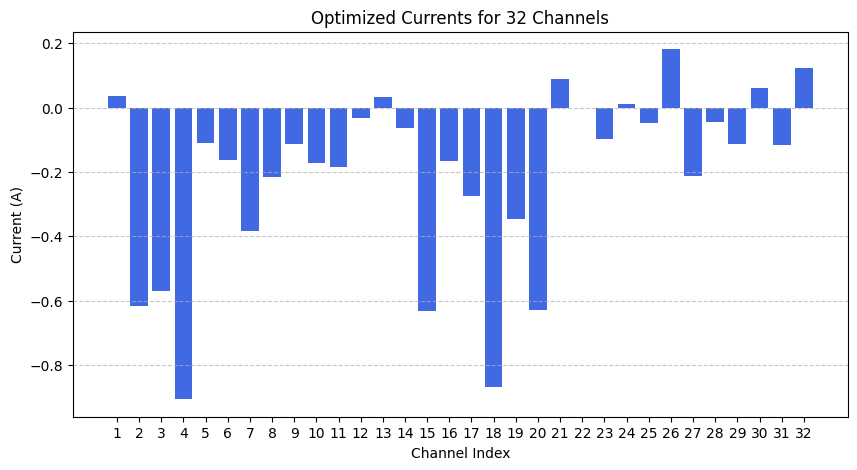

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(shim_currents) + 1),shim_currents, color='royalblue')

plt.xlabel("Channel Index")
plt.ylabel("Current (A)")
plt.title("Optimized Currents for 32 Channels")
plt.xticks(range(1, len(shim_currents) + 1))  

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
B0_optimized =  B0_target - np.tensordot(B0_array, current, axes=([-1], [0]))
B0_opt_img = nib.Nifti1Image(B0_optimized, affine)
nib.save(B0_opt_img, "B0_optimized.nii.gz")
fslmaths("./B0_optimized.nii.gz").mul("./ref_test_nii/ref_nii/ref_bet_mask.nii.gz").run("B0_optimized_regis.nii.gz")

NameError: name 'affine' is not defined

In [3]:
# 目标场图
target_nii = nib.load(r"./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz") 
B0_target = target_nii.get_fdata()
B0_regis = nib.load(r"./ref_test_nii/as_nii/as_deltaB0_hertz.nii.gz")
B0_regis_data = B0_regis.get_fdata()
print(np.mean(B0_target))
print(np.mean(B0_regis_data))

# Apply Gaussian smoothing to sham data
# sham_data = gaussian_filter(B0_target, sigma=0.2)
sham_data = B0_target
sham_data[sham_data == 0] = np.nan
sham_data = np.transpose(sham_data, (1, 0, 2))

# Apply Gaussian smoothing to shim data
# shim_data = gaussian_filter(B0_regis_data, sigma=0.2)
shim_data = B0_regis_data
shim_data[shim_data == 0] = np.nan
shim_data = np.transpose(shim_data, (1, 0, 2))

norm = matplotlib.colors.Normalize(vmin=-100, vmax=100)

fig, axs = plt.subplots(10, 20, figsize=(40, 40), dpi=500, sharex=True, sharey=True)
axs = axs.ravel() 
len_slices = np.size(sham_data, 2)

for i in range(len_slices):
    im = axs[i * 2].imshow(sham_data[:, :, i], cmap='jet', norm=norm)
    axs[i * 2].set_title(f'Sham {i + 1}')
    axs[i * 2].invert_yaxis()
    axs[i * 2].set_axis_off()

    axs[i * 2 + 1].imshow(shim_data[:, :, i], cmap='jet', norm=norm)
    axs[i * 2 + 1].set_title(f'Shim {i + 1}')
    axs[i * 2 + 1].invert_yaxis()
    axs[i * 2 + 1].set_axis_off()

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) 
colorbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal' )
colorbar.ax.tick_params(labelsize=30) 
colorbar.set_label("Field map (Hz)",fontsize = 30)
plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('B0_map(ppm).png')
plt.close()


FileNotFoundError: No such file or no access: 'ref_test_nii/as_nii/as_deltaB0_hertz.nii.gz'

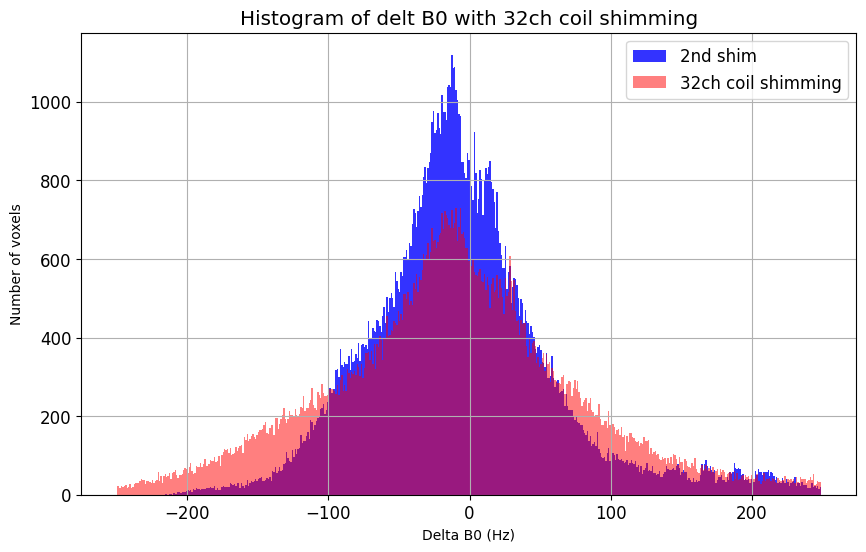

In [17]:
unshimmed_data = nib.load(r'./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz')
unshimmed_data = unshimmed_data.get_fdata()
unshimmed_data_nan = np.where(unshimmed_data == 0, np.nan, unshimmed_data)
unshimmed_values = unshimmed_data_nan[~np.isnan(unshimmed_data_nan)] 

shimmed_data = nib.load(r'./ref_test_nii/as_nii/as_deltaB0_hertz.nii.gz')
shimmed_data = shimmed_data.get_fdata()
shimmed_data_nan = np.where(shimmed_data == 0, np.nan, shimmed_data)
shimmed_values = shimmed_data_nan[~np.isnan(shimmed_data_nan)]

plt.figure(figsize=(10, 6),dpi = 100)
plt.hist(unshimmed_values.flatten(), bins=np.arange(-250, 250, 1), color='blue', alpha=0.8, label='2nd shim')
plt.hist(shimmed_values.flatten(), bins=np.arange(-250, 250, 1), color='red', alpha=0.5, label='32ch coil shimming')
# plt.hist(values_coil_shimming.flatten(), bins=np.arange(-2, 2.05, 0.02), color='red', alpha=0.4, label='coil_shimming')
plt.rcParams.update({'font.size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of delt B0 with 32ch coil shimming')
plt.xlabel('Delta B0 (Hz)')
plt.ylabel('Number of voxels')
plt.legend()
plt.grid(True)
plt.show()

